This notebook documents part 2 of the complementarity of image and demographic information: the ability of latent space extracted from Autoencoders to predict mode choice and trip generation.

In [2]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir

plt.rcParams.update({"font.size":12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_version = '1571'

model_type = 'SAE'
model_code = 'M1_A1'
sampling = 's'

zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '22021402'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [4]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [5]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [6]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [7]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

In [8]:
auto_train = y[~train_test_index,1]
auto_test = y[train_test_index,1]

pt_train = y[~train_test_index,3]
pt_test = y[train_test_index,3]

active_train = y[~train_test_index,0]
active_test = y[train_test_index,0]

trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]


# 1. Linear Regression

Highlight:

Auto Lasso
Parameter: 3.00e-04 Train R2: 0.7074 	 Test R: 0.6966 	 Nonzero coef: 132

Auto Ridge
Parameter: 1.00e+01 Train R2: 0.7656 	 Test R: 0.7267

PT Lasso
Parameter: 1.00e-04 Train R2: 0.6486 	 Test R: 0.5349 	 Nonzero coef: 209

PT Ridge
Parameter: 1.00e+01 Train R2: 0.6856 	 Test R: 0.5561

Active Lasso
Parameter: 2.00e-04 Train R2: 0.6585 	 Test R: 0.6040 	 Nonzero coef: 158

Active Ridge
Parameter: 1.00e+01 Train R2: 0.7123 	 Test R: 0.6091

Trip Gen Lasso
Parameter: 1.00e-01 Train R2: 0.2968 	 Test R: 0.2061 	 Nonzero coef: 34

Trip Gen Ridge
Parameter: 8.00e+01 Train R2: 0.3982 	 Test R: 0.2069

### 1.1 Auto Share

In [64]:
# Linear Regression without Regularization
lr = linear_model.LinearRegression()
lr.fit(x_train, auto_train)
# with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#     f.write("%s,%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
#         lr.score(x_train, auto_train), lr.score(x_test, auto_test), 'lr', zoomlevel,
#         np.sum(lr.coef_ != 0), len(lr.coef_)))
print("Train R2: %.4f \t Test R2: %.4f" % (lr.score(x_train, auto_train), lr.score(x_test, auto_test)))

Train R2: 1.0000 	 Test R2: -0.5727


In [65]:
# Lasso
for a in (1e-4)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, auto_train), 
                                                                                  lasso.score(x_test, auto_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+00, tolerance: 7.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9657 	 Test R: -0.2055 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.346e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-05 Train R2: 0.9556 	 Test R: 0.2199 	 Nonzero coef: 1798


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.8245 	 Test R: 0.6305 	 Nonzero coef: 564


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-04 Train R2: 0.7398 	 Test R: 0.6423 	 Nonzero coef: 287


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.279e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 3.00e-04 Train R2: 0.6942 	 Test R: 0.6366 	 Nonzero coef: 176


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.245e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 4.00e-04 Train R2: 0.6681 	 Test R: 0.6228 	 Nonzero coef: 140


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.437e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-04 Train R2: 0.6484 	 Test R: 0.6168 	 Nonzero coef: 105


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.847e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 6.00e-04 Train R2: 0.6353 	 Test R: 0.6160 	 Nonzero coef: 92


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.469e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 7.00e-04 Train R2: 0.6261 	 Test R: 0.6132 	 Nonzero coef: 75


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.340e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 8.00e-04 Train R2: 0.6185 	 Test R: 0.6077 	 Nonzero coef: 69


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.525e-01, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-03 Train R2: 0.6038 	 Test R: 0.5919 	 Nonzero coef: 57


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.284e-02, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-03 Train R2: 0.5610 	 Test R: 0.5445 	 Nonzero coef: 30
Parameter: 5.00e-03 Train R2: 0.4755 	 Test R: 0.4378 	 Nonzero coef: 13


In [67]:
# Ridge

for a in (5e+0)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, auto_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, auto_train), 
                                                              ridge.score(x_test, auto_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.46374e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.04756e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 0.9401 	 Test R: -0.5934
Parameter: 5.00e-01 Train R2: 0.9313 	 Test R: 0.5258
Parameter: 5.00e+00 Train R2: 0.8045 	 Test R: 0.6644
Parameter: 1.00e+01 Train R2: 0.7604 	 Test R: 0.6688
Parameter: 1.50e+01 Train R2: 0.7356 	 Test R: 0.6671
Parameter: 2.00e+01 Train R2: 0.7189 	 Test R: 0.6643
Parameter: 2.50e+01 Train R2: 0.7064 	 Test R: 0.6613
Parameter: 3.00e+01 Train R2: 0.6966 	 Test R: 0.6585
Parameter: 3.50e+01 Train R2: 0.6887 	 Test R: 0.6558
Parameter: 4.00e+01 Train R2: 0.6820 	 Test R: 0.6532
Parameter: 5.00e+01 Train R2: 0.6712 	 Test R: 0.6484
Parameter: 1.00e+02 Train R2: 0.6410 	 Test R: 0.6305
Parameter: 2.50e+02 Train R2: 0.6050 	 Test R: 0.5991


### 1.2 PT

In [68]:
# Lasso
for a in (1e-4)*np.array([0,0.1,1,2,3,4,5,6,7,8,9,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, pt_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, pt_train), 
                                                                                  lasso.score(x_test, pt_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e-01, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9647 	 Test R: -0.4727 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.707e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-05 Train R2: 0.9315 	 Test R: 0.1211 	 Nonzero coef: 1447


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.621e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.6686 	 Test R: 0.4007 	 Nonzero coef: 275


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-04 Train R2: 0.5573 	 Test R: 0.4486 	 Nonzero coef: 111


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 3.00e-04 Train R2: 0.5104 	 Test R: 0.4515 	 Nonzero coef: 62


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e-01, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 4.00e-04 Train R2: 0.4891 	 Test R: 0.4436 	 Nonzero coef: 48


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.693e-02, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-04 Train R2: 0.4752 	 Test R: 0.4345 	 Nonzero coef: 27


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.042e-03, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 6.00e-04 Train R2: 0.4643 	 Test R: 0.4234 	 Nonzero coef: 24
Parameter: 7.00e-04 Train R2: 0.4555 	 Test R: 0.4129 	 Nonzero coef: 20
Parameter: 8.00e-04 Train R2: 0.4465 	 Test R: 0.4020 	 Nonzero coef: 18
Parameter: 9.00e-04 Train R2: 0.4392 	 Test R: 0.3923 	 Nonzero coef: 16
Parameter: 1.00e-03 Train R2: 0.4313 	 Test R: 0.3811 	 Nonzero coef: 16
Parameter: 2.00e-03 Train R2: 0.3848 	 Test R: 0.3388 	 Nonzero coef: 8
Parameter: 5.00e-03 Train R2: 0.3334 	 Test R: 0.2915 	 Nonzero coef: 5


In [71]:
# Ridge

for a in (1e+1)*np.array([0,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
# for a in (5e0) * np.array([0, 4.5,4.6,4.7,4.8,4.9, 5, 5.1,5.2,5.3,5.4,5.5]):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, pt_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, pt_train), 
                                                              ridge.score(x_test, pt_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.46374e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 0.0373 	 Test R: -1.8961
Parameter: 5.00e+00 Train R2: 0.7567 	 Test R: 0.4224
Parameter: 6.00e+00 Train R2: 0.7404 	 Test R: 0.4298
Parameter: 7.00e+00 Train R2: 0.7266 	 Test R: 0.4353
Parameter: 8.00e+00 Train R2: 0.7147 	 Test R: 0.4398
Parameter: 9.00e+00 Train R2: 0.7043 	 Test R: 0.4435
Parameter: 1.00e+01 Train R2: 0.6950 	 Test R: 0.4465
Parameter: 2.00e+01 Train R2: 0.6365 	 Test R: 0.4597
Parameter: 3.00e+01 Train R2: 0.6051 	 Test R: 0.4625
Parameter: 4.00e+01 Train R2: 0.5844 	 Test R: 0.4625
Parameter: 5.00e+01 Train R2: 0.5693 	 Test R: 0.4616
Parameter: 1.00e+02 Train R2: 0.5280 	 Test R: 0.4545
Parameter: 2.00e+02 Train R2: 0.4943 	 Test R: 0.4428
Parameter: 5.00e+02 Train R2: 0.4574 	 Test R: 0.4204


### 1.3 Active

In [72]:
for a in (1e-4)*np.array([0,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, active_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, active_train), 
                                                                                  lasso.score(x_test, active_test), 
                                                                                  np.sum(lasso.coef_ != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.983e-01, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Parameter: 0.00e+00 Train R2: 0.9579 	 Test R: -0.2282 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-05 Train R2: 0.8410 	 Test R: 0.4854 	 Nonzero coef: 832


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 6.00e-05 Train R2: 0.8178 	 Test R: 0.5048 	 Nonzero coef: 721


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 7.00e-05 Train R2: 0.7955 	 Test R: 0.5153 	 Nonzero coef: 643


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 8.00e-05 Train R2: 0.7766 	 Test R: 0.5180 	 Nonzero coef: 576


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 9.00e-05 Train R2: 0.7600 	 Test R: 0.5238 	 Nonzero coef: 524


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.7445 	 Test R: 0.5216 	 Nonzero coef: 466


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.119e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 2.00e-04 Train R2: 0.6444 	 Test R: 0.5047 	 Nonzero coef: 223


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.788e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 3.00e-04 Train R2: 0.5911 	 Test R: 0.5036 	 Nonzero coef: 141


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 4.00e-04 Train R2: 0.5579 	 Test R: 0.4916 	 Nonzero coef: 108


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.783e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 5.00e-04 Train R2: 0.5372 	 Test R: 0.4820 	 Nonzero coef: 82


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.946e-02, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-03 Train R2: 0.4902 	 Test R: 0.4651 	 Nonzero coef: 35
Parameter: 2.00e-03 Train R2: 0.4436 	 Test R: 0.4222 	 Nonzero coef: 24
Parameter: 5.00e-03 Train R2: 0.3562 	 Test R: 0.3287 	 Nonzero coef: 12


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e-02, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [29]:
# Ridge

# for a in (1e+1)*np.array([0,0.1,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,10,20,50]):
for a in (1e+1)*np.array([0,1, 1.5, 2, 1.5, 3]):
    
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, active_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, active_train), 
                                                              ridge.score(x_test, active_test)))

Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -0.3472
Parameter: 1.00e+01 Train R2: 0.7555 	 Test R: 0.5881
Parameter: 1.50e+01 Train R2: 0.7269 	 Test R: 0.6001
Parameter: 2.00e+01 Train R2: 0.7074 	 Test R: 0.6060
Parameter: 1.50e+01 Train R2: 0.7269 	 Test R: 0.6001
Parameter: 3.00e+01 Train R2: 0.6811 	 Test R: 0.6114


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.20557e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


### 1.4 Trip Generation

In [38]:
for a in (1e-2)*np.array([0,0.1,6,7,8,10,11,12,13,14,15,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d" % (a, lasso.score(x_train, trpgen_train), 
                                                                                  lasso.score(x_test, trpgen_test), 
                                                                                  np.sum(lasso.coef_ != 0)))
#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+03, tolerance: 3.630e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Parameter: 0.00e+00 Train R2: 0.9876 	 Test R: -2.5644 	 Nonzero coef: 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+04, tolerance: 3.630e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-03 Train R2: 0.9552 	 Test R: -1.1065 	 Nonzero coef: 1481
Parameter: 6.00e-02 Train R2: 0.3600 	 Test R: 0.1904 	 Nonzero coef: 64
Parameter: 7.00e-02 Train R2: 0.3392 	 Test R: 0.2006 	 Nonzero coef: 56
Parameter: 8.00e-02 Train R2: 0.3210 	 Test R: 0.2057 	 Nonzero coef: 49
Parameter: 1.00e-01 Train R2: 0.2968 	 Test R: 0.2061 	 Nonzero coef: 34
Parameter: 1.10e-01 Train R2: 0.2901 	 Test R: 0.2051 	 Nonzero coef: 32
Parameter: 1.20e-01 Train R2: 0.2845 	 Test R: 0.2024 	 Nonzero coef: 29
Parameter: 1.30e-01 Train R2: 0.2799 	 Test R: 0.2015 	 Nonzero coef: 26
Parameter: 1.40e-01 Train R2: 0.2752 	 Test R: 0.2003 	 Nonzero coef: 22
Parameter: 1.50e-01 Train R2: 0.2707 	 Test R: 0.1989 	 Nonzero coef: 23
Parameter: 2.00e-01 Train R2: 0.2482 	 Test R: 0.1862 	 Nonzero coef: 17
Parameter: 5.00e-01 Train R2: 0.1208 	 Test R: 0.0963 	 Nonzero coef: 9


In [40]:
# Ridge

for a in (1e+1)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, trpgen_train), 
                                                              ridge.score(x_test, trpgen_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.47584e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -2.4222
Parameter: 1.00e+00 Train R2: 0.8127 	 Test R: -0.3083
Parameter: 1.00e+01 Train R2: 0.5850 	 Test R: 0.1181
Parameter: 2.00e+01 Train R2: 0.5189 	 Test R: 0.1722
Parameter: 3.00e+01 Train R2: 0.4820 	 Test R: 0.1911
Parameter: 4.00e+01 Train R2: 0.4566 	 Test R: 0.1997
Parameter: 5.00e+01 Train R2: 0.4373 	 Test R: 0.2039
Parameter: 6.00e+01 Train R2: 0.4219 	 Test R: 0.2059
Parameter: 7.00e+01 Train R2: 0.4091 	 Test R: 0.2068
Parameter: 8.00e+01 Train R2: 0.3982 	 Test R: 0.2069
Parameter: 1.00e+02 Train R2: 0.3804 	 Test R: 0.2063
Parameter: 2.00e+02 Train R2: 0.3295 	 Test R: 0.1990
Parameter: 5.00e+02 Train R2: 0.2723 	 Test R: 0.1859


# 2. Linear Regression (PyTorch)

In [24]:
def pytorch_lr(w1_list, lr_list, x1, x2, y1, y2):
    
    mseloss = nn.MSELoss(reduction='sum')
    
    trainset = SurveyDataset(torch.tensor(x1,  dtype=torch.float), torch.tensor(y1, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)

    testset = SurveyDataset(torch.tensor(x2, dtype=torch.float), torch.tensor(y2, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    # decay rates for embedding
#     w1_list = [0]
    # decay rates for demo (There is no demo in this case)
    w2_list = [0]
    # lr_list = [0.005,0.01, 0.02]
#     lr_list = [0.002]

    dim_demo = 0
    dim_embed = x1.shape[1]

    for lr in lr_list:

        for w1, w2 in itertools.product(w1_list, w2_list):

            # model setup
            model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo)

#             print(model)
            embed_params = []
            demo_params = []
            other_params = []
            for name, m in model.named_parameters():
        #             print(name)
                if 'embed' in name:
                    embed_params.append(m)
                elif 'demo' in name:
                    demo_params.append(m)
                else:
                    other_params.append(m)

#             optimizer = torch.optim.Adam([{'params':demo_params,'lr':lr}])
            optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr},
                                          {'params':demo_params,'weight_decay':w2, 'lr':lr},
                                          {'params':other_params,'weight_decay':0, 'lr':lr}])
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#             print(optimizer)
#             print(demo_params)
            
            # model training
            ref1 = 0
            ref2 = 0

            for epoch in range(1000):

                mse_ = 0

                for batch, (x_batch, y_batch) in enumerate(trainloader):
                    # Compute prediction and loss
                    pred = model(x_batch, None)
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                    # Backpropagation
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()

                train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
                train_mse = mse_/len(trainset)

                if epoch % 20 == 0:
                    print(f"[epoch: {epoch:>3d}] Train MSE : {train_mse:.4f} R2 score: {train_r:.3f} ")
                loss_ = train_mse

                if epoch % 5 == 0:
                    if epoch >=40:
                        if (np.abs(loss_ - ref1)/ref1<0.0005) & (np.abs(loss_ - ref2)/ref2<0.0005):
                            print("Early stopping at epoch", epoch)
                            print(ref2, ref1, loss_)
                            break
                        if (ref1 < loss_) & (ref1 < ref2):
                            print("Diverging. stop.")
                            break
                        if loss_ < best:
                            best = loss_
                            best_epoch = epoch
                    else:
                        best = loss_
                        best_epoch = epoch

                    ref2 = ref1
                    ref1 = loss_

                if epoch % 20 == 0:

                    mse_ = 0 

                    for batch, (x_batch, y_batch) in enumerate(testloader):
                        pred = model(x_batch, None)
                        pred = F.relu(pred).squeeze()

                        mse = mseloss(pred, y_batch)
                        mse_ += mse.item()
                        
#                     print(len(testset))

                    test_mse = mse_/len(testset)
                    test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                    print(f"[epoch: {epoch:>3d}] Test MSE {test_mse:.4f} R2 score: {test_r:.3f} ")
    return model

    #         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
    #             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
    #                 (model_run_date, model_type, zoomlevel, "LR", lr, w1, 
    #                   train_rmse, train_r, test_rmse, test_r))

In [56]:
model = pytorch_lr(w1_list=[0.0003], lr_list=[0.001], x1=x_train, x2=x_test, y1=auto_train, y2=auto_test)


[epoch:   0] Train MSE : 0.6495 R2 score: -10.921 
[epoch:   0] Test MSE 0.6646 R2 score: -12.113 
[epoch:  20] Train MSE : 0.5560 R2 score: -9.205 
[epoch:  20] Test MSE 0.5561 R2 score: -9.973 
[epoch:  40] Train MSE : 0.3196 R2 score: -4.867 
[epoch:  40] Test MSE 0.3185 R2 score: -5.284 
[epoch:  60] Train MSE : 0.1762 R2 score: -2.234 
[epoch:  60] Test MSE 0.1752 R2 score: -2.457 
[epoch:  80] Train MSE : 0.1045 R2 score: -0.918 
[epoch:  80] Test MSE 0.1029 R2 score: -1.031 
[epoch: 100] Train MSE : 0.0732 R2 score: -0.344 
[epoch: 100] Test MSE 0.0708 R2 score: -0.396 
[epoch: 120] Train MSE : 0.0615 R2 score: -0.128 
[epoch: 120] Test MSE 0.0581 R2 score: -0.146 
[epoch: 140] Train MSE : 0.0576 R2 score: -0.057 
[epoch: 140] Test MSE 0.0536 R2 score: -0.057 
[epoch: 160] Train MSE : 0.0564 R2 score: -0.036 
[epoch: 160] Test MSE 0.0520 R2 score: -0.026 
[epoch: 180] Train MSE : 0.0560 R2 score: -0.028 
[epoch: 180] Test MSE 0.0514 R2 score: -0.013 
[epoch: 200] Train MSE : 0.0

In [32]:
pytorch_lr(w1_list=[0.00001], lr_list=[0.5], x1=x_train, x2=x_test, y1=pt_train, y2=pt_test)


[epoch:   0] Train MSE : 0.0146 R2 score: -0.502 
[epoch:   0] Test MSE 0.0839 R2 score: -7.997 
[epoch:  20] Train MSE : 0.0146 R2 score: -0.502 
[epoch:  20] Test MSE 0.0141 R2 score: -0.513 
[epoch:  40] Train MSE : 0.0146 R2 score: -0.502 
Early stopping at epoch 40
0.01458367667407261 0.014583678022975463 0.014583679371878315


LR(
  (embed): Linear(in_features=2048, out_features=1, bias=True)
)

In [71]:
torch.save(model.state_dict(), out_dir+"image_weights.pt")

# 2. MNL for Mode Share

In [9]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [10]:
sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)

In [11]:
def mnl_torch(lr_list, wd_list):
    
    for (lr, wd) in itertools.product(lr_list, wd_list):
        
        print(f"[lr: {lr:.4f}, wd: {wd:3.2e}]")

        # model setup
        model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#         print(optimizer)
        # model training

        ref1 = 0
        ref2 = 0

        for epoch in range(5000):

            kl_ = 0
            mse_ = 0
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader):
                
                # Compute prediction and loss
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util, dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()
                mse = mse.sum()

                # Backpropagation
                optimizer.zero_grad()
                kl.backward()
                optimizer.step()

            train_kl = kl_/len(trainset)
            train_mse = np.sqrt(mse_/len(trainset))
            train_mse1 = np.sqrt(mse1_/len(trainset))
            train_mse2 = np.sqrt(mse2_/len(trainset))
            train_mse3 = np.sqrt(mse3_/len(trainset))
            train_mse4 = np.sqrt(mse4_/len(trainset))

            train_r1 = 1-mse1_/sst_train[0]
            train_r2 = 1-mse2_/sst_train[1]
            train_r3 = 1-mse3_/sst_train[2]
            train_r4 = 1-mse4_/sst_train[3]

            loss_ = train_kl

            if epoch % 5 == 0:

                kl_ = 0
                mse_ = 0 
                mse1_ = 0
                mse2_ = 0
                mse3_ = 0
                mse4_ = 0

                for batch, (x_batch, y_batch) in enumerate(testloader):
                    
                    util = model(x_batch)
                    probs = torch.log(nn.functional.softmax(util,dim=1))
                    kl = kldivloss(probs, y_batch)
            #         kl = kldivloss(torch.log(util), y_batch)
                    kl_ += kl.item()

                    mse = mseloss(torch.exp(probs), y_batch)
            #         mse = mseloss(util, y_batch)
                    mse_ += mse.sum().item()
                    mse1_ += mse[:,0].sum().item()
                    mse2_ += mse[:,1].sum().item()
                    mse3_ += mse[:,2].sum().item()
                    mse4_ += mse[:,3].sum().item()

                test_kl = kl_/len(testset)
                test_mse = np.sqrt(mse_/len(testset))
                test_mse1 = np.sqrt(mse1_/len(testset))
                test_mse2 = np.sqrt(mse2_/len(testset))
                test_mse3 = np.sqrt(mse3_/len(testset))
                test_mse4 = np.sqrt(mse4_/len(testset))

                r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
                r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
                r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
                r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

                if epoch >= 40:
#                     if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
#                         print("Early stopping at epoch", epoch)
#                         break
#                     if (ref1 < loss_) & (ref1 < ref2):
#                         print("Diverging. stop.")
#                         break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                        output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                else:
                    best = loss_
                    best_epoch = epoch
                    output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                ref2 = ref1
                ref1 = loss_

#             if epoch % 20 == 0:

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} RMSE {train_mse:.3f}")
#                    # {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
#                 print(f"\t\t\t\t\t\t Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} RMSE {np.sqrt(mse_/len(testset)):.3f}")
#                    #     {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
#                 print(f"\t\t\t\t\t\t Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#         with open(out_dir+"BA_mode_choice.csv", "a") as f:
#             f.write("%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % 
#                     (("MNL",lr, wd)+output))

        print(f"[epoch: {best_epoch:>3d}] Train KL loss: {output[0]:.3f} Train R2 score: {output[12]:.3f} {output[13]:.3f} {output[14]:.3f} {output[15]:.3f} ")
        print(f"[epoch: {best_epoch:>3d}] Test KL loss: {output[6]:.3f} Test R2 score: {output[16]:.3f} {output[17]:.3f} {output[18]:.3f} {output[19]:.3f} ")
        print()
        
    return model

In [46]:
model = mnl_torch(lr_list=[0.0005], wd_list=[0, 1e-7, 1e-6])

[lr: 0.0005, wd: 0.00e+00]
[epoch: 4985] Train KL loss: 0.095 Train R2 score: 0.712 0.770 0.238 0.716 
[epoch: 4985] Test KL loss: 0.110 Test R2 score: 0.572 0.680 -0.267 0.458 

[lr: 0.0005, wd: 1.00e-07]
[epoch: 4995] Train KL loss: 0.096 Train R2 score: 0.698 0.763 0.271 0.707 
[epoch: 4995] Test KL loss: 0.110 Test R2 score: 0.575 0.682 -0.271 0.462 

[lr: 0.0005, wd: 1.00e-06]
[epoch: 4995] Train KL loss: 0.096 Train R2 score: 0.706 0.765 0.232 0.706 
[epoch: 4995] Test KL loss: 0.110 Test R2 score: 0.573 0.685 -0.263 0.465 



In [ ]:
mnl_torch(lr_list=[0.005], wd_list=[1e-5, 1e-4, 1e-3])

In [ ]:
mnl_torch(lr_list=[0.005], wd_list=[1e-2, 1e-1])

In [ ]:
mnl_torch(lr_list=[0.005], wd_list=[1,2,3,4,5])

In [ ]:
mnl_torch(lr_list=[0.005], wd_list=[10])

In [22]:
model = mnl_torch(lr_list=[0.0005], wd_list=[2])

[lr: 0.0005, wd: 2.00e+00]
[epoch: 4995] Train KL loss: 0.093 Train R2 score: 0.722 0.774 0.195 0.683 
[epoch: 4995] Test KL loss: 0.098 Test R2 score: 0.601 0.729 -0.263 0.550 



In [29]:
torch.save(model.state_dict(), out_dir+"ac4_sae_22021402.pt")


## Substitution Curve

In [12]:
label = {0: "Active", 1:"Auto", 3:"Public Transit"}

In [13]:
model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])

In [19]:
saved = torch.load(out_dir+"ac4_sae_220502.pt")
model.load_state_dict(saved);

In [59]:
model

MNL(
  (beta): Linear(in_features=2048, out_features=4, bias=True)
)

In [33]:
select_ct = "17_31_842100"
# target_ct = "17_31_839100" # 17_31_802300
target_ct = "17_31_839100"

In [83]:
ct_train = np.array(unique_ct)[~train_test_index].tolist()

In [89]:
ct_train[1192]

'17_43_846515'

In [84]:
ct_train.index(target_ct)

591

In [34]:
select = np.array(unique_ct)[~train_test_index].tolist().index(select_ct)
target = np.array(unique_ct)[~train_test_index].tolist().index(target_ct)


In [77]:
target

591

In [85]:
y_train[591]

array([0.06543985, 0.86598945, 0.01792632, 0.05064437])

In [87]:
x_train

array([[0.87705916, 0.2264165 , 0.48505932, ..., 0.3346961 , 0.7416978 ,
        0.653571  ],
       [0.6863482 , 0.33222264, 0.4920233 , ..., 0.26621485, 0.7509318 ,
        0.4335001 ],
       [0.8488263 , 0.24462366, 0.45612377, ..., 0.3412737 , 0.7206503 ,
        0.5076797 ],
       ...,
       [0.7737112 , 0.6777059 , 0.4930932 , ..., 0.39824638, 0.37632185,
        0.40257534],
       [0.79223454, 0.82337284, 0.5619807 , ..., 0.39771435, 0.42390347,
        0.37690142],
       [0.7629267 , 0.32102448, 0.5110604 , ..., 0.29693416, 0.6177071 ,
        0.6276804 ]], dtype=float32)

In [23]:
util = model(torch.tensor(x_train))
util = torch.log(F.softmax(util))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [24]:
kldivloss(util,torch.tensor(y_train))/len(x_train)

tensor(0.0932, dtype=torch.float64, grad_fn=<DivBackward0>)

In [35]:
for alpha in np.linspace(0, 1, 6):
    temp = x_train[select].copy() * (1-alpha) + x_train[target].copy() * (alpha)

    if alpha == 0:
        test_in = x_train[select].copy().reshape(1, -1)
    else:
        test_in = np.concatenate([test_in, temp.reshape(1,-1)], axis=0)

test_in = torch.tensor(test_in, dtype=torch.float32)

In [36]:
util = model(torch.tensor(test_in))
probs = F.softmax(util).detach().numpy()
welfare = np.log(np.sum(np.exp(util.detach().numpy()), axis=1))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [37]:
welfare

array([1.6346313, 1.5712262, 1.537279 , 1.5320381, 1.5534903, 1.5987531],
      dtype=float32)

In [32]:
welfare

array([1.6346313, 1.7078968, 1.8118355, 1.942305 , 2.094722 , 2.2646515],
      dtype=float32)

In [27]:
probs

array([[0.26730236, 0.5195505 , 0.04384274, 0.16930443],
       [0.22736342, 0.60420567, 0.0430031 , 0.12542772],
       [0.18755025, 0.68142915, 0.04090541, 0.0901152 ],
       [0.15065801, 0.7484014 , 0.03789131, 0.06304928],
       [0.11839546, 0.8041122 , 0.03433735, 0.04315493],
       [0.0914266 , 0.8489716 , 0.03057653, 0.02902521]], dtype=float32)

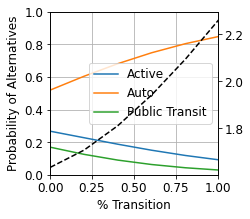

In [31]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
for i in [0,1,3]:
    ax.plot(np.linspace(0,1.01,test_in.shape[0]), probs[:,i], label=label[i])
# ax2 = ax.twinx()
# ax2.plot(np.linspace(0,1.01,test_in.shape[0]), welfare, '--', c='k', label="welfare")

#     print(probs[:,i])
ax.set_ylabel("Probability of Alternatives")
ax.set_xlabel("% Transition")
ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid()
plt.show()
# fig.savefig(out_dir+"/substitution_curves/"+select_ct+"_"+target_ct+".png",bbox_inches='tight')

In [128]:
x_train[[2,3],:]

array([[0.26258385, 0.46862403, 0.41123223, ..., 0.88273513, 0.66203994,
        0.7422787 ],
       [0.3279127 , 0.3692272 , 0.43320718, ..., 0.88564366, 0.71464527,
        0.7797907 ]], dtype=float32)

In [153]:
ct_train.index("17_31_81600")

780

In [70]:
util = model(torch.tensor(x_train[[345,298,789,766,780],:]))

In [78]:
util = model(torch.tensor(x_train[[591,345,298,789,766,780],:]))

In [81]:
F.softmax(util)

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1097, 0.6140, 0.1345, 0.1417],
        [0.2185, 0.5266, 0.1155, 0.1394],
        [0.1302, 0.6635, 0.0859, 0.1204],
        [0.1810, 0.5821, 0.0995, 0.1373],
        [0.4175, 0.3875, 0.0949, 0.1001],
        [0.2329, 0.5157, 0.0960, 0.1554]], grad_fn=<SoftmaxBackward0>)

In [155]:
util

tensor([[ 1.0336,  0.4847, -1.6340, -0.0597],
        [ 0.6245,  0.5732, -1.4503,  0.3164],
        [ 0.3936,  0.7518, -1.6667,  0.2015],
        [ 0.7723,  0.6468, -1.7494,  0.0114],
        [ 0.8743,  0.3601, -1.4041, -0.0361]], grad_fn=<AddmmBackward0>)

In [156]:
util = util.detach().numpy()
util = np.log(np.sum(np.exp(util), axis=1))

In [146]:
util

array([1.7615857, 2.1936176], dtype=float32)

In [157]:
util

array([1.7177628, 1.6578373, 1.6124746, 1.6600351, 1.6175466],
      dtype=float32)